## Imports

In [1]:
from time import sleep
import librosa
import numpy as np
import sounddevice as sd
from speech_bandwidth_expansion.sbe_system.SpeechBandwidthExtension.sbe import SpeechBandwidthExtension
import matplotlib.pyplot as plt
import scipy.signal as ss

## Apply Bandwidth Expansion and load other signals for comparison

In [2]:
file = 'sample2'
filepath = f"../data/GeorgeManos/{file}.wav"

sbe = SpeechBandwidthExtension(filepath, window_length=80)
sig, fs = sbe.produce_wideband_speech()
S_wb, fs_wb = librosa.load(filepath, sr=16000)
S_nb, fs_nb = sbe.S_nb, sbe.fs_nb
sig_interp, fs_interp = sbe.upsample_signal()

# Zero imputation for fair comparisson
S_wb = np.concatenate([S_wb, np.zeros((abs(len(sig_interp) - len(S_wb))))])
sig = np.concatenate([sig, np.zeros((abs(len(sig) - len(S_wb))))])

## Listen to the signals!

In [3]:
import soundfile as sf

# Narrowband signal:
sd.play(S_nb, fs_nb)
sf.write(str(f'../output_speechfiles/{file}/nb.wav'), S_nb, fs_nb)
sleep(len(S_nb) / fs_nb + 1)

# # Wideband signal:
sd.play(S_wb, fs_wb)
sf.write(str(f'../output_speechfiles/{file}/wb.wav'), S_wb, fs_wb)
sleep(len(S_wb) / fs_wb + 1)

# Reconstructed wideband:
sd.play(sig, fs)
sf.write(str(f'../output_speechfiles/{file}/sbe.wav'), sig, fs)
sleep(len(sig) / fs + 1)

# Simply interpolated
sd.play(sig_interp, fs_interp)
sf.write(str(f'../output_speechfiles/{file}/interp.wav'), sig_interp, fs_interp)
sleep(len(sig_interp) / fs_interp + 1)

## Compute Metrics
3 metrics are used: MSE, Spectral Convergence, L1-Norm of MEL spectrogram difference.

### Compute Mean Squared Error (MSE)

$$ MSE = \frac{1}{N} \sum_{i=0}^{N-1} (s[i] - \hat{s}[i]])^2  $$

In [4]:
MSE = np.power((S_wb - sig_interp), 2).mean()
print('Interpolated Signal MSE:', MSE)
MSE = np.power((S_wb - sig), 2).mean()
print('SBE Signal MSE:', MSE)

Interpolated Signal MSE: 5.8357257077751845e-05
SBE Signal MSE: 0.002903210086956534


### Spectral Convergence

$$ \mathnormal{L}_{sc}(s[n], \hat{s}[n]) =  \frac{\||STFT(s[n])| - |STFT(\hat{s}[n])|\|_F}{\||STFT(s[n])|\|_F}$$

Where STFT is the discrete Short Time Fourier Transform of the ground truth speech signal, and $\|A\|_F$ denotes the *Frobenius* norm of a matrix A:
$$\|A\|_F = \sqrt{\sum_{i=0}^{N-1}\sum_{j=0}^{K-1} |\alpha_{i,j}|^2} $$

In [5]:
def stft_mag(sig, fs):
    return abs(ss.stft(sig, fs)[2])

def spectral_convergence(X, X_hat):
    return np.linalg.norm(x=(X - X_hat), ord='fro') / np.linalg.norm(x=X, ord='fro')

In [6]:
SC = spectral_convergence(X=stft_mag(sig=S_wb, fs=fs_wb), X_hat=stft_mag(sig=sig_interp, fs=fs_interp))
print('Interpolated Signal SC:', SC)
SC = spectral_convergence(X=stft_mag(sig=S_wb, fs=fs_wb), X_hat=stft_mag(sig=sig, fs=fs))
print('SBE Signal SC:', SC)

Interpolated Signal SC: 0.1618157960721424
SBE Signal SC: 0.988586069318584


### L1 Norm of MEL Spectrogram difference

In [7]:
MEL = np.linalg.norm(x=(
        librosa.feature.melspectrogram(y=S_wb, sr=fs_wb) -
        librosa.feature.melspectrogram(y=sig_interp, sr=fs_interp)
    ), ord=1)
print('Interpolated Signal MEL:', MEL)

MEL = np.linalg.norm(x=(
        librosa.feature.melspectrogram(y=S_wb, sr=fs_wb) -
        librosa.feature.melspectrogram(y=sig, sr=fs)
    ), ord=1)
print('SBE Signal MEL:', MEL)


Interpolated Signal MEL: 8.117700742956258
SBE Signal MEL: 1706.4549431483056


## Plot signals in time domain

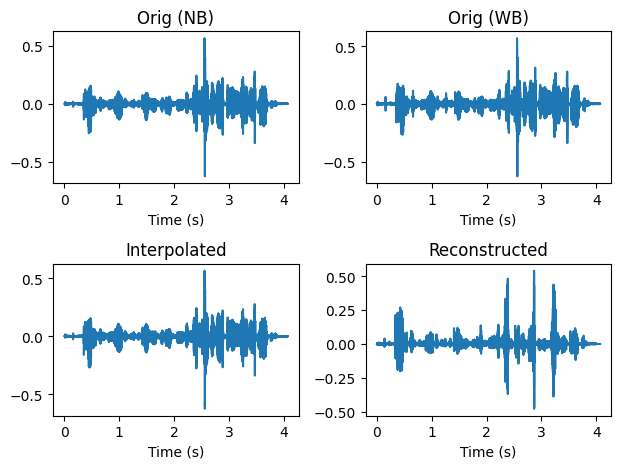

In [8]:
t_nb = np.arange(start=0, stop=len(S_nb)) / fs_nb
t_wb = np.arange(start=0, stop=len(S_wb)) / fs_wb

plt.figure()
plt.subplot(2,2,1)
plt.plot(t_nb, S_nb)
plt.title('Orig (NB)')
plt.xlabel('Time (s)')

plt.subplot(2,2,2)
plt.plot(t_wb, S_wb)
plt.title('Orig (WB)')
plt.xlabel('Time (s)')

plt.subplot(2,2,3)
plt.plot(t_wb, sig_interp)
plt.title('Interpolated')
plt.xlabel('Time (s)')

plt.subplot(2,2,4)
plt.plot(t_wb, sig)
plt.title('Reconstructed')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.savefig(f'../plots/' + file + '/waveforms.png')

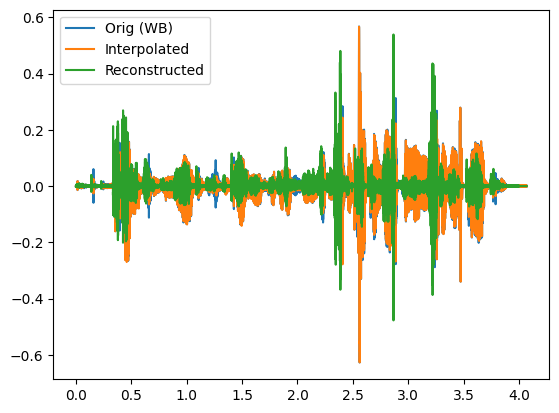

In [9]:
t_wb = np.arange(start=0, stop=len(S_wb)) / fs_wb

plt.figure()
plt.plot(t_wb, S_wb, label='Orig (WB)')
plt.plot(t_wb, sig_interp, label='Interpolated')
plt.plot(t_wb, sig, label='Reconstructed')
plt.legend()
plt.savefig(f'../plots/' + file + '/waveforms_merged.png')

# Compare Spectrograms

In [10]:
def plot_spectrogram(sig, fs, title=None):
    """
    Plots spectrogram for the input signal fs
    """
    # Plot the signal
    plt.figure()
    plt.title(title)

    # Plot the spectrogram
    plt.specgram(sig, Fs=fs)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency")

    plt.show()

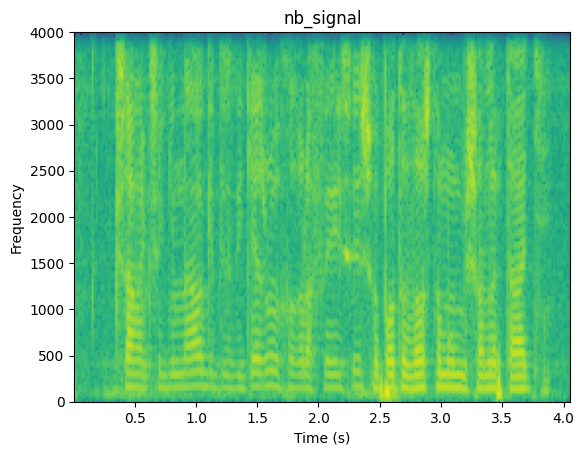

In [11]:
plot_spectrogram(sig=S_nb, fs=fs_nb, title='nb_signal')

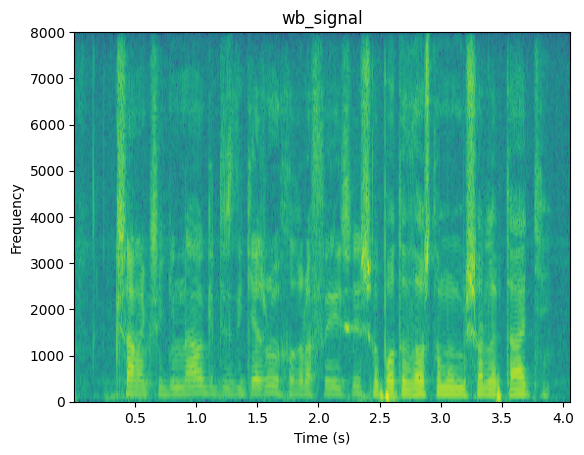

In [12]:
plot_spectrogram(sig=S_wb, fs=fs_wb, title='wb_signal')

/opt/homebrew/Caskroom/miniconda/base/envs/sbe/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


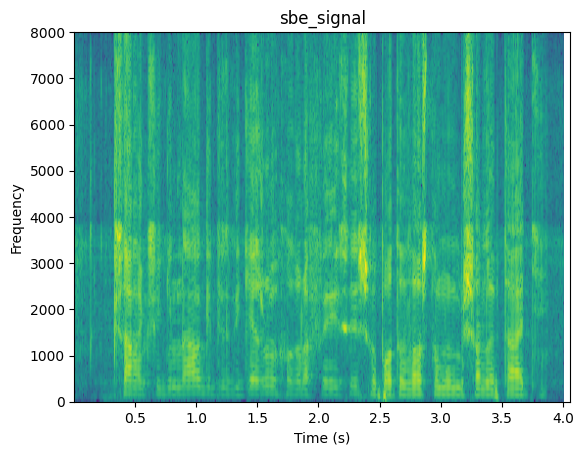

In [13]:
plot_spectrogram(sig=sig, fs=fs, title='sbe_signal')

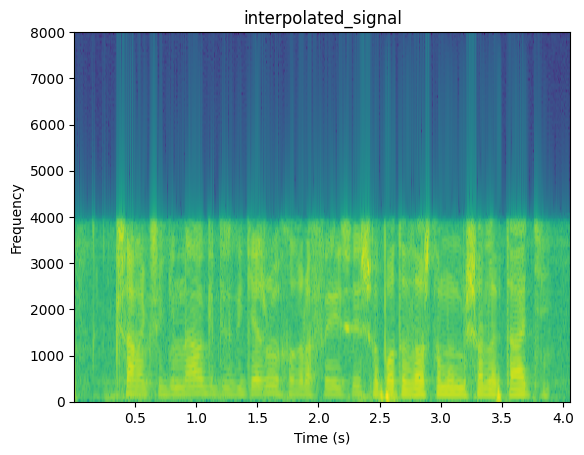

In [14]:
plot_spectrogram(sig=sig_interp, fs=fs_interp, title='interpolated_signal')